## Installations and importations

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
%matplotlib ipympl

### Load images

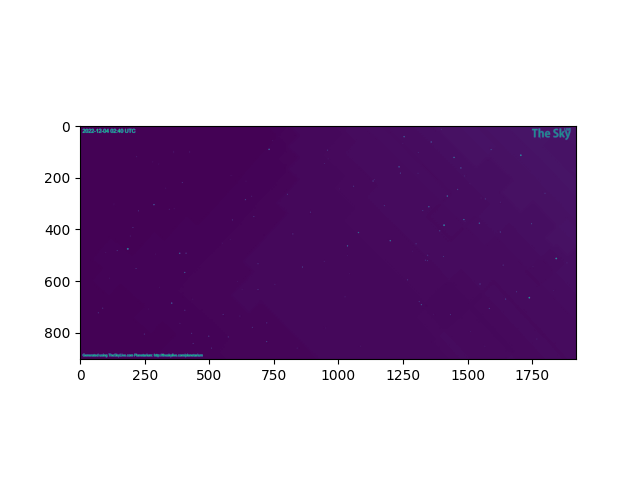

In [2]:
Image_Src_dir = 'SkyLive_8_320_images'
Image_files = os.listdir(Image_Src_dir)

IMAGES = []
for file in Image_files:
    IMAGES.append(cv2.imread(Image_Src_dir+"\\"+file))    
    IMAGES[-1] = cv2.cvtColor(IMAGES[-1], cv2.COLOR_BGR2GRAY)
    IMAGES[-1] = np.array(IMAGES[-1], dtype=np.float_)/255

# Plot(1st image)
plt.figure(1)
plt.imshow(IMAGES[0])
plt.show()

### Crop images if neccessary

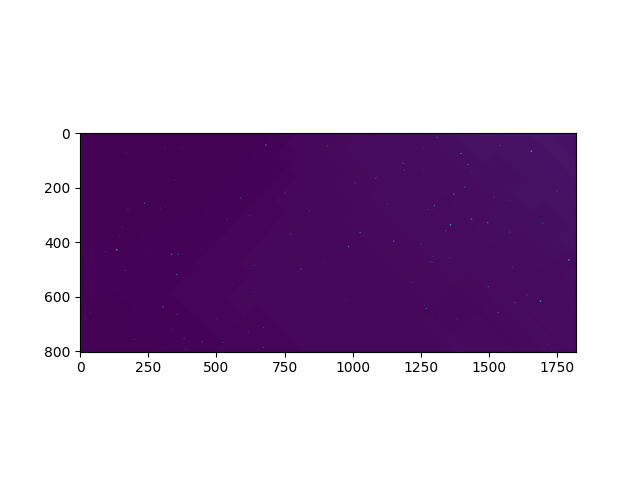

In [3]:
Crop_border = 50
for image_no in range(len(IMAGES)):
    IMAGES[image_no] = IMAGES[image_no][Crop_border:IMAGES[image_no].shape[0]-Crop_border, Crop_border:IMAGES[image_no].shape[1]-Crop_border]

plt.figure(2)
plt.imshow(IMAGES[0])
plt.show()

### Threshold

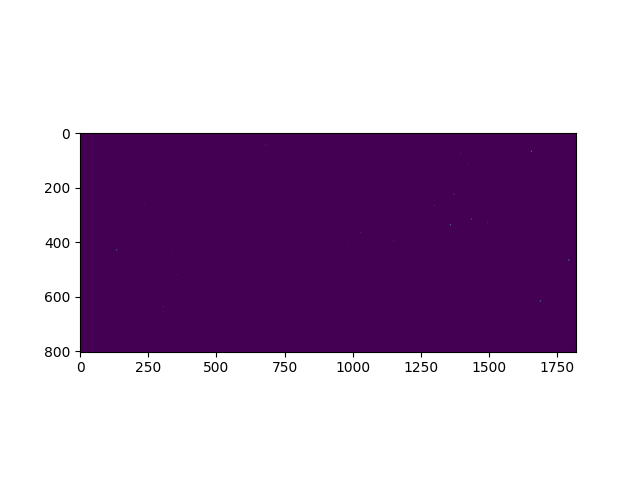

In [4]:
Threshold = 0.8
for image_no in range(len(IMAGES)):
    IMAGES[image_no][IMAGES[image_no] < Threshold] = 0
    #IMAGES[image_no][IMAGES[image_no] >= Threshold] = 1

plt.figure(3)
plt.imshow(IMAGES[0])
plt.show()

### Identify star locations

In [5]:
STARS = [] #Store size and location of all stars

for image_no in range(len(IMAGES)):
    print("Locating stars in Image-",image_no)
    image_copy = np.copy(IMAGES[image_no])

    Star_indices = np.argwhere(image_copy)
    stars = []
    while(Star_indices.shape[0] != 0):
        Rand_pos = Star_indices[random.randrange(Star_indices.shape[0])]

        Up_shift = 0
        Right_shift = 0
        Down_shift = 0
        Left_shift = 0
        #Rand_pos = np.array([615, 1689], dtype=np.int_)        
        while True:
            if(Rand_pos[0]-Up_shift != 0):
                if(np.any(image_copy[Rand_pos[0]-Up_shift, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1])):
                    Up_shift = Up_shift+1
                    continue
            if(Rand_pos[1]+Right_shift != image_copy.shape[1]-1):
                if(np.any(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]+Right_shift])):
                    Right_shift = Right_shift+1
                    continue
            if(Rand_pos[0]+Down_shift != image_copy.shape[0]-1):
                if(np.any(image_copy[Rand_pos[0]+Down_shift, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1])):
                    Down_shift = Down_shift+1
                    continue
            if(Rand_pos[1]-Left_shift != 0):
                if(np.any(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift])):
                    Left_shift = Left_shift+1
                    continue
            break

        #Find star size
        star_size = np.sum(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1])

        #Find star row
        star_row = np.dot(np.array(range(Rand_pos[0]-Up_shift, Rand_pos[0]+Down_shift+1)), np.sum(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1], axis=1))/star_size

        #Find star column    
        star_col = np.dot(np.array(range(Rand_pos[1]-Left_shift, Rand_pos[1]+Right_shift+1)), np.sum(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1], axis=0))/star_size    

        #Add star to list
        stars.append(np.array([star_size, star_row, star_col]))

        #Remove found star
        image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1] = 0

        #New star indices
        Star_indices = np.argwhere(image_copy)
                
    #The array of all stars
    STARS.append(np.array(stars))

Locating stars in Image- 0
Locating stars in Image- 1
Locating stars in Image- 2
Locating stars in Image- 3
Locating stars in Image- 4


### Plot located stars (only image-1)

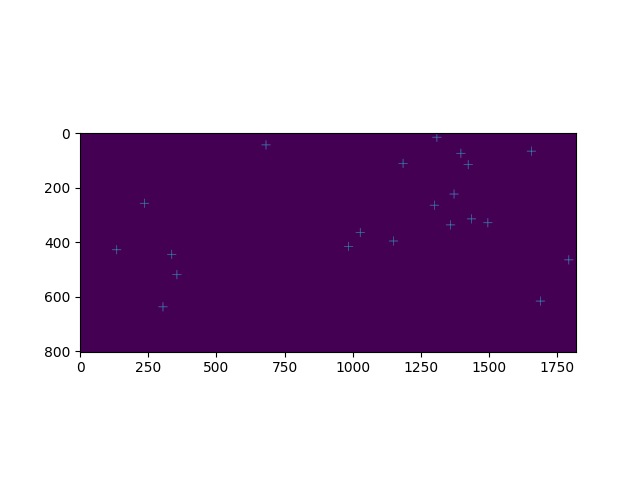

In [6]:
Plot_length = 16
image_copy = IMAGES[0].copy()
for star in STARS[0]:
    image_copy[max([round(star[1])-Plot_length, 0]) : min([round(star[1])+Plot_length+1, image_copy.shape[0]]),  round(star[2])] = 1
    image_copy[round(star[1]), max([round(star[2])-Plot_length, 0]) : min([round(star[2])+Plot_length+1, image_copy.shape[1]])] = 1
plt.figure(4)
plt.imshow(image_copy)
plt.show()

### Sorting the stars based on size

In [7]:
for image_no in range(len(STARS)):
    STARS[image_no] = STARS[image_no][np.argsort(STARS[image_no][:,0])[::-1],:]

### Forming the triangles

In [21]:
Num_stars = 10

def Compute_dist(point1, point2):
    return np.sqrt( (point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 )

TRIANGLES = []
for image_no in range(1):
    stars_copy = STARS[image_no][:min([Num_stars, STARS[image_no].shape[0]]),:]
    triangles = []

    Triangle_vertices = np.array([0,1,2], dtype=np.int_)
    while(Triangle_vertices[0]<stars_copy.shape[0]):
        Triangle_vertices[1] = Triangle_vertices[0]+1
        while(Triangle_vertices[1]<stars_copy.shape[0]):
            Triangle_vertices[2] = Triangle_vertices[1]+1
            while(Triangle_vertices[2]<stars_copy.shape[0]):

                Side1 = Compute_dist(stars_copy[Triangle_vertices[0],1:], stars_copy[Triangle_vertices[1],1:])
                Side2 = Compute_dist(stars_copy[Triangle_vertices[1],1:], stars_copy[Triangle_vertices[2],1:])
                Side3 = Compute_dist(stars_copy[Triangle_vertices[0],1:], stars_copy[Triangle_vertices[2],1:])
                triangles.append(np.sort(np.array([Side1, Side2, Side3])))

                Triangle_vertices[2] += 1
            Triangle_vertices[1] += 1
        Triangle_vertices[0] += 1
    TRIANGLES.append(np.array(triangles))